<a href="https://colab.research.google.com/github/xiomara-udea/COMPETENCIA-AI4ENG-UDEA---Semestre-2025-1/blob/main/99_modelo_soluci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

replicating local resources


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
import xgboost as xgb

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"xiomaraperezudea","key":"c7779ed01610d092aea8f2d5f696098f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.08GB/s]


In [ ]:
!unzip -l udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip

Archive:  udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
  4716673  2025-03-25 16:54   submission_example.csv
 59185250  2025-03-25 16:54   test.csv
143732449  2025-03-25 16:54   train.csv
---------                     -------
207634372                     3 files


In [ ]:
!unzip udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip

Archive:  udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip
  inflating: submission_example.csv  
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
dtr = pd.read_csv("train.csv")
print (dtr.shape)
dts = pd.read_csv("test.csv")
print (dts.shape)

(692500, 21)
(296786, 20)


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
import numpy as np

class SaberProCleaner:
    def __init__(self, scaler_type='minmax'):
        # Elegir escalador
        if scaler_type == 'standard':
            self.scaler = StandardScaler()
        else:
            self.scaler = MinMaxScaler()

        self.columnas_onehot = ['PERIODO', 'ESTU_PRGM_DEPARTAMENTO', 'AREA_ACADEMICA']
        self.columns_after_onehot = None
        self.columnas_a_normalizar = ['ESTU_VALORMATRICULAUNIVERSIDAD_num', 'ESTU_HORASSEMANATRABAJA_num']

        self.mapa_valormatricula = {
            'Menos de 500 mil': 250_000,
            'Entre 500 mil y menos de 1 millón': 750_000,
            'Entre 1 millón y menos de 2.5 millones': 1_750_000,
            'Entre 2.5 millones y menos de 4 millones': 3_250_000,
            'Entre 4 millones y menos de 5.5 millones': 4_750_000,
            'Entre 5.5 millones y menos de 7 millones': 6_250_000,
            'Más de 7 millones': 8_000_000,
            'No pagó matrícula': 0
        }

        self.mapa_horas_trabajo = {
            '0': 0,
            'Menos de 10 horas': 5,
            'Entre 10 y 20 horas': 15,
            'Entre 21 y 30 horas': 25,
            'Más de 30 horas': 35
        }

        self.binarios_bool = {
            'FAMI_TIENEINTERNET': {'Si': True, 'No': False},
            'FAMI_TIENELAVADORA': {'Si': True, 'No': False},
            'FAMI_TIENEAUTOMOVIL': {'Si': True, 'No': False},
            'ESTU_PRIVADO_LIBERTAD': {'S': True, 'N': False},
            'ESTU_PAGOMATRICULAPROPIO': {'Si': True, 'No': False},
            'FAMI_TIENECOMPUTADOR': {'Si': True, 'No': False}
        }

        self.educacion_orden = {
            'Ninguno': 1,
            'Primaria incompleta': 2,
            'Primaria completa': 3,
            'Secundaria (Bachillerato) incompleta': 4,
            'Secundaria (Bachillerato) completa': 5,
            'Técnica o tecnológica incompleta': 6,
            'Técnica o tecnológica completa': 7,
            'Educación profesional incompleta': 8,
            'Educación profesional completa': 9,
            'Postgrado': 10
        }

        self.rendimiento_orden = {
            'bajo': 1,
            'medio-bajo': 2,
            'medio-alto': 3,
            'alto': 4
        }

    def limpiar_programa(self, texto):
        if pd.isnull(texto): return texto
        texto = texto.upper().strip()
        texto = (texto.replace('Á','A').replace('É','E').replace('Í','I')
                      .replace('Ó','O').replace('Ú','U').replace('Ñ','N')
                      .replace('¿','').replace('¡','').replace('.', '')
                      .replace('-', ' ').replace('_', ' '))
        while '  ' in texto:
            texto = texto.replace('  ', ' ')
        return texto

    def clasificar_area(self, programa):
        programa = programa.upper()
        if any(p in programa for p in ['INGENIERIA', 'INGENIERÍA']):
            return 'Ingenierías'
        elif any(p in programa for p in ['MEDICINA', 'ENFERMERIA', 'SALUD', 'FISIOTERAPIA', 'ODONTOLOGIA', 'NUTRICION', 'TERAPIA']):
            return 'Salud'
        elif any(p in programa for p in ['DERECHO']):
            return 'Derecho'
        elif any(p in programa for p in ['ADMINISTRACION', 'CONTADURIA', 'ECONOMIA']):
            return 'Económico-administrativas'
        elif any(p in programa for p in ['BIOLOGIA', 'FISICA', 'QUIMICA', 'MATEMATICA']):
            return 'Ciencias Básicas'
        elif any(p in programa for p in ['PSICOLOGIA', 'SOCIOLOGIA', 'TRABAJO SOCIAL']):
            return 'Ciencias Sociales y Humanas'
        elif any(p in programa for p in ['ARTES', 'DISEÑO', 'MUSICA']):
            return 'Artes'
        elif any(p in programa for p in ['LICENCIATURA', 'EDUCACION']):
            return 'Educación'
        elif any(p in programa for p in ['COMUNICACION']):
            return 'Comunicación'
        elif any(p in programa for p in ['AGRONOMIA', 'VETERINARIA']):
            return 'Agropecuarias y Medio Ambiente'
        else:
            return 'Otras'

    def fit_transform(self, df):
        return self._transform(df.copy(), fit_scaler=True)

    def transform(self, df):
        return self._transform(df.copy(), fit_scaler=False)

    def _transform(self, df, fit_scaler):
        df = df.drop(columns=['FAMI_TIENEINTERNET.1'], errors='ignore')

        df['ESTU_VALORMATRICULAUNIVERSIDAD_num'] = df['ESTU_VALORMATRICULAUNIVERSIDAD'].map(self.mapa_valormatricula)
        df['ESTU_HORASSEMANATRABAJA_num'] = df['ESTU_HORASSEMANATRABAJA'].map(self.mapa_horas_trabajo)

        # Imputar con mediana
        df['ESTU_VALORMATRICULAUNIVERSIDAD_num'] = df['ESTU_VALORMATRICULAUNIVERSIDAD_num'].fillna(df['ESTU_VALORMATRICULAUNIVERSIDAD_num'].median())
        df['ESTU_HORASSEMANATRABAJA_num'] = df['ESTU_HORASSEMANATRABAJA_num'].fillna(df['ESTU_HORASSEMANATRABAJA_num'].median())

        columnas_fillna_mode = [
            'FAMI_ESTRATOVIVIENDA',
            'FAMI_TIENEINTERNET',
            'FAMI_EDUCACIONPADRE',
            'FAMI_TIENELAVADORA',
            'FAMI_TIENEAUTOMOVIL',
            'ESTU_PAGOMATRICULAPROPIO',
            'FAMI_TIENECOMPUTADOR',
            'FAMI_EDUCACIONMADRE'
        ]
        for col in columnas_fillna_mode:
            if col in df.columns:
                df[col] = df[col].fillna(df[col].mode()[0])

        df['PROGRAMA_LIMPIO'] = df['ESTU_PRGM_ACADEMICO'].apply(self.limpiar_programa)
        df['AREA_ACADEMICA'] = df['PROGRAMA_LIMPIO'].apply(self.clasificar_area)
        df.drop(columns=['ESTU_PRGM_ACADEMICO', 'PROGRAMA_LIMPIO'], inplace=True)

        for col, mapping in self.binarios_bool.items():
            if col in df.columns:
                df[col] = df[col].map(mapping).astype(bool)

        for col in ['FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE']:
            df[col + '_ord'] = df[col].map(self.educacion_orden)

        if 'RENDIMIENTO_GLOBAL' in df.columns:
            df['RENDIMIENTO_GLOBAL_ord'] = df['RENDIMIENTO_GLOBAL'].map(self.rendimiento_orden)
            df.drop(columns=['RENDIMIENTO_GLOBAL'], inplace=True)

        df.drop(columns=[
            'FAMI_ESTRATOVIVIENDA',
            'FAMI_EDUCACIONPADRE',
            'FAMI_EDUCACIONMADRE',
            'ESTU_VALORMATRICULAUNIVERSIDAD',
            'ESTU_HORASSEMANATRABAJA'
        ], errors='ignore', inplace=True)

        df = pd.get_dummies(df, columns=self.columnas_onehot, dtype=bool)

        if fit_scaler:
            self.columns_after_onehot = df.columns.tolist()

        if not fit_scaler:
            for col in self.columns_after_onehot:
                if col not in df:
                    df[col] = False
            df = df[self.columns_after_onehot]

        scaled = self.scaler.fit_transform(df[self.columnas_a_normalizar]) if fit_scaler else self.scaler.transform(df[self.columnas_a_normalizar])
        df_scaled = pd.DataFrame(scaled, columns=[c + '_scaled' for c in self.columnas_a_normalizar], index=df.index)
        df = pd.concat([df, df_scaled], axis=1)
        df.drop(columns=self.columnas_a_normalizar, inplace=True)

        return df


In [ ]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 21.5 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1345
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 67
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 1.25139
[100]	valid_0's multi_logloss: 1.23352
[150]	valid_0's multi_logloss: 1.22734
[200]	valid_0's multi_logloss: 1.2245
[250]	valid_0's multi_logloss: 1.22303
[300]	valid_0's multi_logloss: 1.22219
[350]	valid_0's multi_logloss: 1.22175
[400]	valid_0's multi_logloss: 1.22144
[450]	valid_0's multi_logloss: 1.22127
[500]	valid_0's mult

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


🎯 Accuracy en validación: 0.4231


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


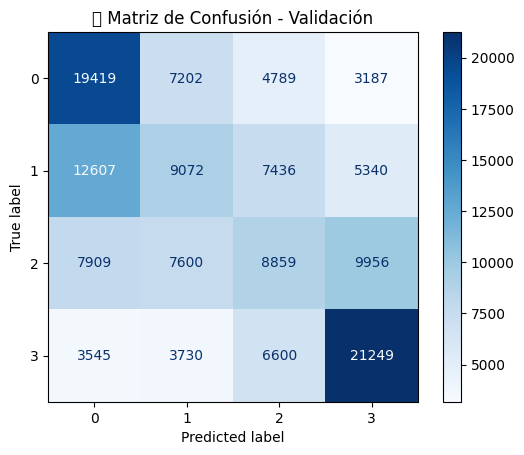

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


       ID RENDIMIENTO_GLOBAL
0  550236               bajo
1   98545         medio-alto
2  499179               alto
3  782980               bajo
4  785185               bajo
✅ Archivo listo: submission_final.csv


In [ ]:
import pandas as pd
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define best_params manualmente
best_params = {
    'learning_rate': 0.0372,
    'num_leaves': 68,
    'max_depth': 10,
    'min_child_samples': 19,
    'subsample': 0.98,
    'colsample_bytree': 0.74,
    'objective': 'multiclass',
    'num_class': 4,
    'class_weight': 'balanced',
    'random_state': 42,
    'n_jobs': -1,
    'n_estimators': 500
}

#  Xtr, ytr, Xts
cols_features = df_train.drop(columns=["RENDIMIENTO_GLOBAL_ord"]).columns
Xtr = df_train[cols_features].values
ytr = df_train["RENDIMIENTO_GLOBAL_ord"].values - 1  # Ajusta si tu codificación empieza en 1
Xts = df_test[cols_features].values

# Split validación interna
Xtr_train, Xtr_valid, ytr_train, ytr_valid = train_test_split(
    Xtr, ytr, test_size=0.2, stratify=ytr, random_state=42
)

# Entrena modelo con callbacks y logs
final_model = LGBMClassifier(**best_params)

final_model.fit(
    Xtr_train, ytr_train,
    eval_set=[(Xtr_valid, ytr_valid)],
    callbacks=[
        lgb.early_stopping(50),
        lgb.log_evaluation(50)
    ]
)

# Accuracy validación
valid_preds = final_model.predict(Xtr_valid)
val_acc = accuracy_score(ytr_valid, valid_preds)
print(f"Accuracy en validación: {val_acc:.4f}")

# Matriz de confusión
cm = confusion_matrix(ytr_valid, valid_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("🔍 Matriz de Confusión - Validación")
plt.show()

#  Predicciones finales test
preds_proba = final_model.predict_proba(Xts)
preds_classes = preds_proba.argmax(axis=1) + 1  # Ajusta a codificación 1–4

#  Map a etiquetas para Kaggle
map_clases = {
    1: 'bajo',
    2: 'medio-bajo',
    3: 'medio-alto',
    4: 'alto'
}

df_submit = pd.DataFrame({
    'ID': dts['ID'].values,
    'RENDIMIENTO_GLOBAL': [map_clases[c] for c in preds_classes]
})

df_submit.to_csv('submission_final.csv', index=False)
print(df_submit.head())
print("Archivo listo: submission_final.csv")


